###  <b> PROBABILITY AND STATISTICS:
#### <b> 1. DATA PROCESSING:

In [1100]:
# Libraries
import os
import math
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.formula.api import ols

from scipy.stats import norm
from geopy.distance import geodesic

##### <b> •	Overview of dirty_data.csv and warehouses.csv

In [1101]:
# CSV file paths
dirty_data_path = r"..\datasets\dirty_data.csv"

# Read data from CSV file
statistics = pd.read_csv(dirty_data_path)

# CSV file paths
warehouses_path= r"..\datasets\warehouses.csv"

# Read data from CSV file
address = pd.read_csv(warehouses_path)

In [1102]:
# Overview of dirty_data CSV file
print(f'Overview of dirty_data CSV file: {statistics.shape}')

Overview of dirty_data CSV file: (500, 16)


##### <b> • Data processing in the "date" column

In [ ]:
# Convert "date" column to datetime type
statistics['date'] = pd.to_datetime(statistics['date'], errors='coerce')

# Sort data by the "date" column
statistics = statistics.sort_values(by='date')

##### <b> • Data processing in the "season" column

In [1104]:
# Check data in the "season" column
print(statistics['season'].unique())

['winter' 'Summer' 'Autumn' 'spring' 'summer' 'Winter' 'Spring' 'autumn']


In [1105]:
# Convert the first character of each value in the "season" column to uppercase
statistics['season'] = statistics['season'].str.capitalize()

# Check data in the "season" column
print(statistics['season'].unique())

['Winter' 'Summer' 'Autumn' 'Spring']


In [1106]:
# Determine season based on month
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'
    
# Sort the "season" column according to the "date" column
statistics['season'] = statistics['date'].dt.month.apply(get_season)

##### <b> •	Data processing in the "order_id" column

In [1107]:
# Check data in the "order_id" column
duplicate_orders = statistics.groupby('order_id').size().reset_index(name='n')
duplicate_orders = duplicate_orders[duplicate_orders['n'] > 1]

# Results displayed after processing
print("Duplicate order IDs:", len(duplicate_orders))

Duplicate order IDs: 0


##### <b> •	Data processing in the "customer_id" column

In [1108]:
# Check data in the "customer_id" column
duplicate_customers = statistics.groupby('customer_id').size().reset_index(name='n')
duplicate_customers = duplicate_customers[duplicate_customers['n'] > 1]

print("Customers who made more than one purchase:", len(duplicate_customers))
print(duplicate_customers)

Customers who made more than one purchase: 6
      customer_id  n
42   ID0245493801  2
181  ID0591274456  2
216  ID0710001161  2
286  ID1463620434  2
385  ID3924911400  2
478  ID6167489462  2


##### <b> •	Data processing in the "is_expedited_delivery" column

In [1109]:
# Check data in the "is_expedited_delivery" column
print(statistics['is_expedited_delivery'].unique())

[False  True]


##### <b> •	Data processing in the "is_happy_customer" column

In [1110]:
# Check data in the "is_happy_customer" column
print(statistics['is_happy_customer'].unique())

[ True False]


##### <b> •	Data processing in the "nearest_warehouse" column

In [1111]:
# Check data in the "nearest_warehouse" column
print(statistics['nearest_warehouse'].unique())

['Thompson' 'Nickolson' 'Bakers' 'nickolson' 'thompson']


In [1112]:
# Convert the first letter of each word in the "nearest_warehouse" column to uppercase
statistics['nearest_warehouse'] = statistics['nearest_warehouse'].str.title()

# Results displayed after processing
print(statistics['nearest_warehouse'].unique())

['Thompson' 'Nickolson' 'Bakers']


##### <b> •	Data processing in the "customer_lat" column

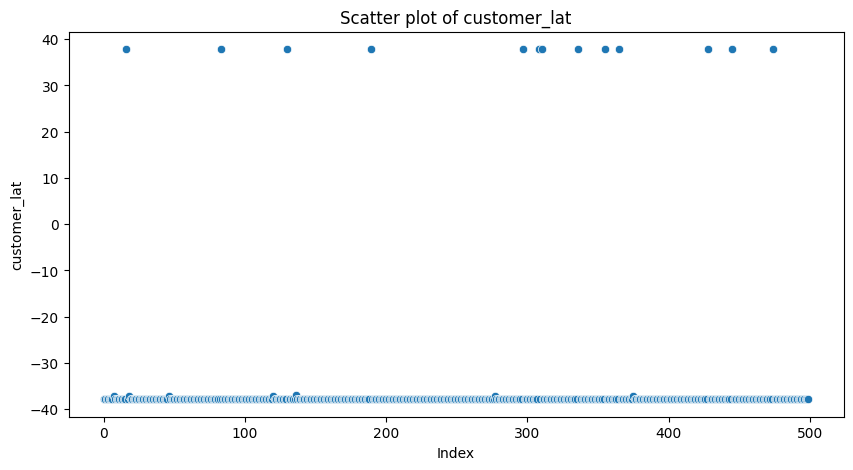

In [ ]:
# Scatter plot of "customer_lat"
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(statistics)), y=statistics['customer_lat'])

plt.title("Scatter plot of customer_lat")
plt.xlabel("Index")
plt.ylabel("customer_lat")
plt.show()

In [1114]:
# Filter values where customer_lat > -37
out_of_range_values = statistics[statistics['customer_lat'] > -37]

# Print the erroneous values
print(out_of_range_values['customer_lat'])

458    37.823507
245    37.823093
282    37.804518
498    37.820071
353    37.810246
309    37.791485
344    37.808119
5      37.820245
297    37.826339
396    37.815897
412    37.807469
4      37.823859
480    37.804082
Name: customer_lat, dtype: float64


In [1115]:
# After changing the sign
statistics['customer_lat'] = statistics['customer_lat'].apply(lambda x: -x if x > 0 else x)

# Recreate this variable to update the data
out_of_range_values = statistics[statistics['customer_lat'] > -37]

# Print results after processing
print(out_of_range_values['customer_lat'])

Series([], Name: customer_lat, dtype: float64)


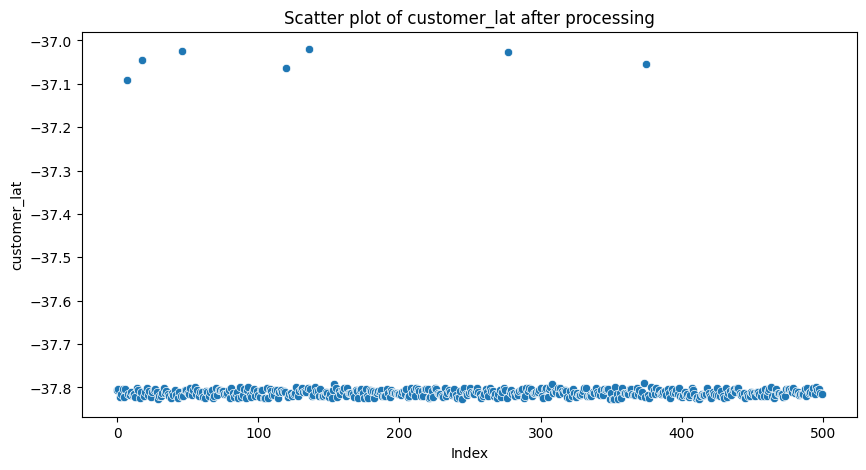

In [1116]:
# Scatter plot of customer_lat after processing
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(statistics)), y=statistics['customer_lat'])

plt.title("Scatter plot of customer_lat after processing")
plt.xlabel("Index")
plt.ylabel("customer_lat")
plt.show()

##### <b> •	Data processing in the "customer_long" column

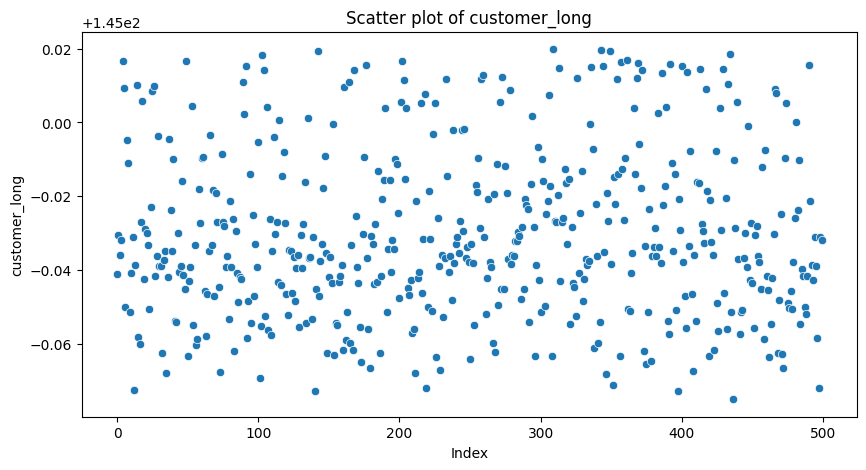

In [1117]:
# Scatter plot of "customer_long"
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(statistics)), y=statistics['customer_long'])

plt.title("Scatter plot of customer_long")
plt.xlabel("Index")
plt.ylabel("customer_long")
plt.show()


##### <b> •	Data processing in the "distance_to_nearest_warehouse" column

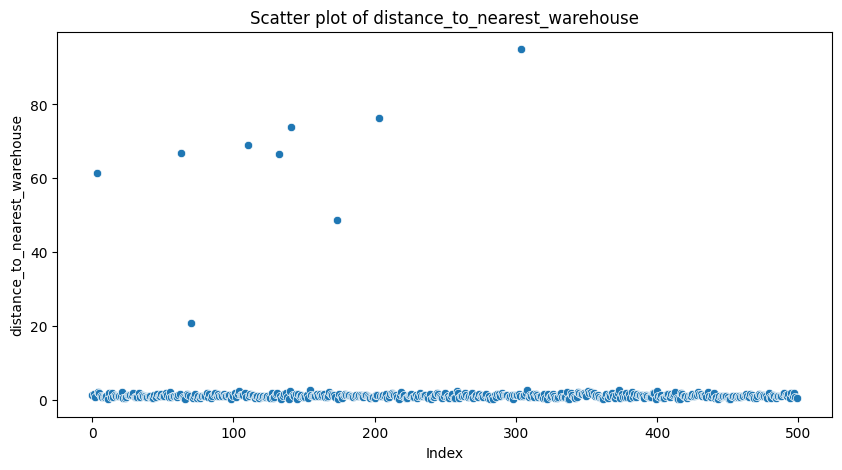

In [1118]:
# Scatter plot of "distance_to_nearest_warehouse"
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(statistics)), y=statistics['distance_to_nearest_warehouse'])

plt.title("Scatter plot of distance_to_nearest_warehouse")
plt.xlabel("Index")
plt.ylabel("distance_to_nearest_warehouse")
plt.show()

In [1119]:
# Calculate Q1, Q3, and IQR
Q1 = statistics['distance_to_nearest_warehouse'].quantile(0.25)
Q3 = statistics['distance_to_nearest_warehouse'].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = statistics[(statistics['distance_to_nearest_warehouse'] < lower_bound) | (statistics['distance_to_nearest_warehouse'] > upper_bound)]

# Print the count
print("Number of outliers:", len(outliers))

Number of outliers: 12


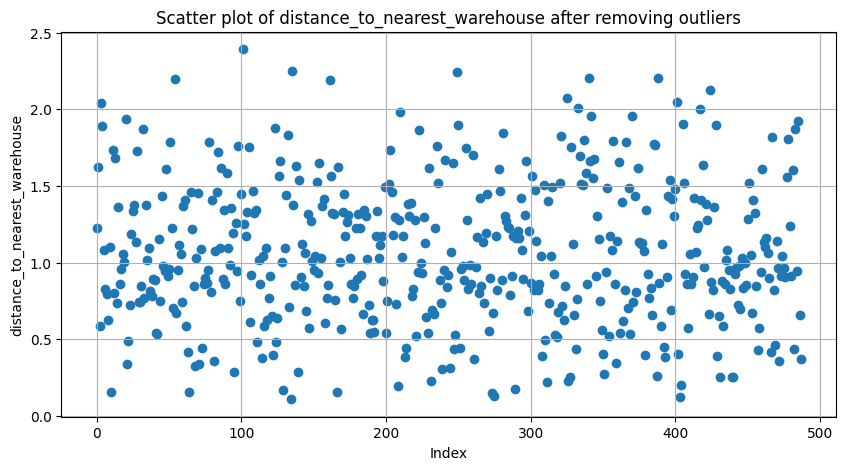

In [1120]:
# Create a copy with outliers removed
clean_data = statistics[
    (statistics['distance_to_nearest_warehouse'] >= lower_bound) &
    (statistics['distance_to_nearest_warehouse'] <= upper_bound)
].reset_index(drop=True)

# Plot scatter plot after filtering outliers
plt.figure(figsize=(10, 5))
plt.scatter(x=range(len(clean_data)), y=clean_data['distance_to_nearest_warehouse'])

plt.title("Scatter plot of distance_to_nearest_warehouse after removing outliers")
plt.xlabel("Index")
plt.ylabel("distance_to_nearest_warehouse")
plt.grid(True)
plt.show()

##### <b> •	Data processing in the "order_total" column

In [1121]:
# Calculate total amount and add 'total_amount' column
statistics['total_amount'] = statistics['order_price'] * ((100 - statistics['coupon_discount']) / 100) + statistics['delivery_charges']

In [1122]:
# Calculate deviation
statistics['deviation'] = abs(statistics['total_amount'] - statistics['order_total'])

In [1123]:
# Assign the "total_amount" column to the "order_total" column
statistics['order_total'] = statistics['total_amount']

In [1124]:
# Check if the deviation is not zero
num_nonzero_deviation = (statistics['deviation'] != 0).sum()

# Display results
print("Check if the deviation is not zero:", num_nonzero_deviation)

Check if the deviation is not zero: 40


##### <b> •	Overview of missing_data.csv

In [1125]:
# CSV file paths
missing_data_path= r"..\datasets\missing_data.csv"

# Read data from CSV file
data_deficiency = pd.read_csv(missing_data_path)

In [1126]:
# Overview of the CSV file missing_data
print(f'Overview of the CSV file missing_data: {data_deficiency.shape}')

Overview of the CSV file missing_data: (500, 16)


##### <b> •	Identify missing data

In [1127]:
# Replace empty strings ("") with NaN
data_deficiency.replace("", np.nan, inplace=True)

# Calculate the total number of missing cells
missing_values = data_deficiency.isna().sum().sum()

# Print the results
print("Number of missing data points:", missing_values)


Number of missing data points: 80


In [1128]:
# Total number of data cells  
total_cells = 500 * 16

# Calculate the missing data rate
missing_rate = missing_values / total_cells

# Print the results
print("Missing data rate:", missing_rate)

Missing data rate: 0.01


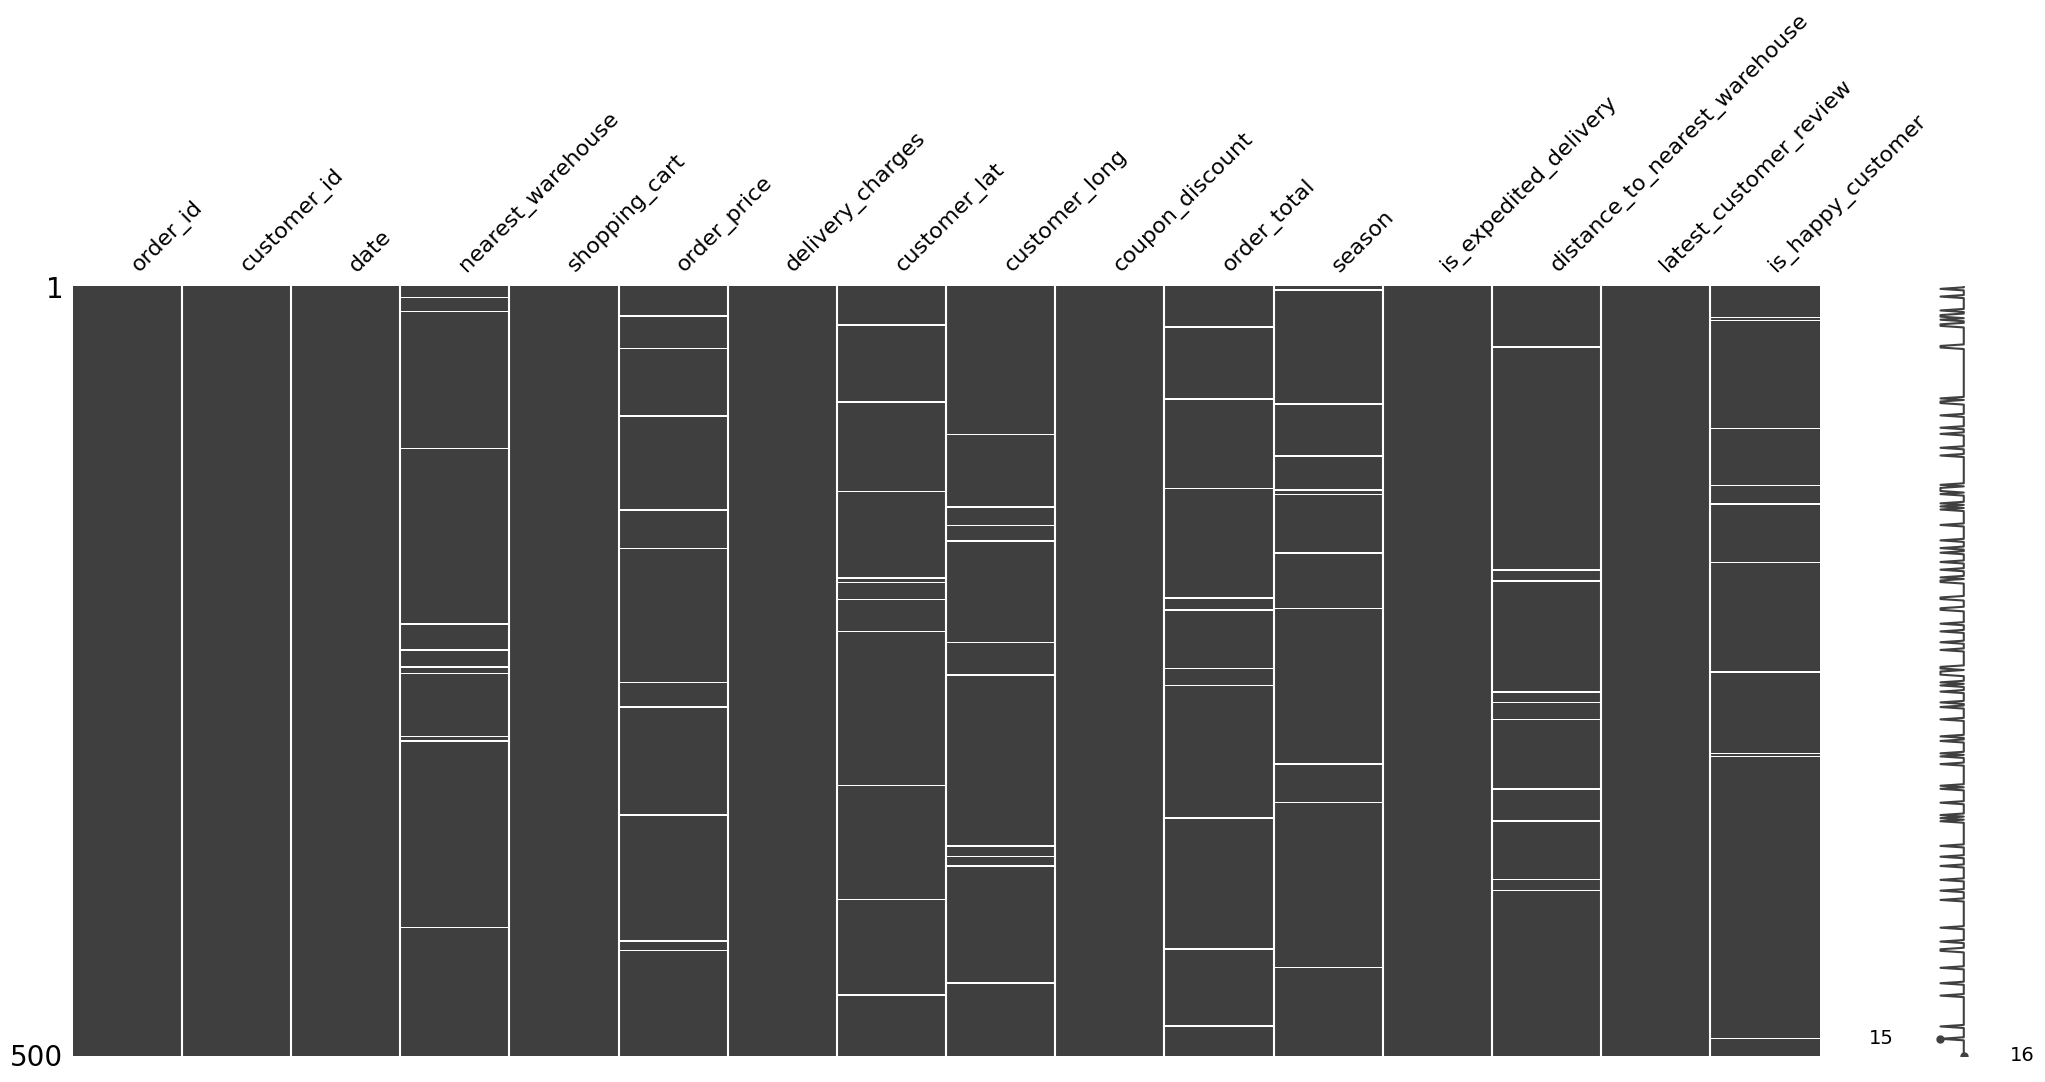

In [1129]:
# Visualize missing data as a bar chart
msno.matrix(data_deficiency)

# Display the chart
plt.show()


##### <b> •	Handle missing data in the "season" column

In [ ]:
# Convert the data type of the "date" column
data_deficiency['date'] = pd.to_datetime(data_deficiency['date'], errors='coerce')

# Function to assign season based on month
def get_season(month):
    if pd.isnull(month):
        return np.nan
    if 1 <= month <= 3:
        return 'Spring'
    elif 4 <= month <= 6:
        return 'Summer'
    elif 7 <= month <= 9:
        return 'Autumn'
    elif 10 <= month <= 12:
        return 'Winter'
    else:
        return np.nan

# Create a new "season" column based on the month of the date
data_deficiency['season'] = data_deficiency['date'].dt.month.apply(get_season)

# Calculate the frequency of each season
season_counts = data_deficiency['season'].value_counts()

# Print the results
print(season_counts.to_string(index=True, header=False))

Winter    147
Autumn    127
Spring    114
Summer    112


##### <b> •	Handle missing data in the "order_total" column

In [1131]:
# Identify rows with missing values in the "order_total" column
mask = (data_deficiency['order_total'].isna() & data_deficiency['order_price'].notna() & data_deficiency['coupon_discount'].notna() & data_deficiency['delivery_charges'].notna())

# Recalculate order_total
data_deficiency.loc[mask, 'order_total'] = (data_deficiency.loc[mask, 'order_price'] * (1 - data_deficiency.loc[mask, 'coupon_discount'] / 100) 
                                         + data_deficiency.loc[mask, 'delivery_charges']).round(2)

##### <b> •	Handle missing data in the "order\_price" column

In [ ]:
# Identify rows where "order_price" can be recalculated
mask = (
    data_deficiency['order_price'].isna() &
    data_deficiency['order_total'].notna() &
    data_deficiency['coupon_discount'].notna() &
    data_deficiency['delivery_charges'].notna()
)

# Recalculate "order_price" 
data_deficiency.loc[mask, 'order_price'] = (
    (data_deficiency.loc[mask, 'order_total'] - data_deficiency.loc[mask, 'delivery_charges']) / (1 - data_deficiency.loc[mask, 'coupon_discount'] / 100)).round(2)

##### <b> •	Handle missing data in the columns "customer\_lat", "customer\_long", and "distance\_to\_nearest\_warehouse"

In [1133]:
# Extract data from the three columns to be checked
data_abc = data_deficiency[['customer_lat', 'customer_long', 'distance_to_nearest_warehouse']]

# Check how many missing values each row has
missing_at_least_two = data_abc.isna().sum(axis=1) >= 2

# Check if at least one row meets the condition
any_missing_at_least_two = missing_at_least_two.any()

# Print the results
if any_missing_at_least_two:
    print("There is at least one row containing 2 or more NA values.")
else:
    print("There are no rows containing at least 2 NA values.")

There are no rows containing at least 2 NA values.


In [ ]:
# Iterate through each row in "missing_data"
for idx, row in data_deficiency.iterrows():
    if pd.isna(row['distance_to_nearest_warehouse']):
        # Customer coordinates
        customer_location = (row['customer_lat'], row['customer_long'])

        # Calculate distance to each warehouse
        distances = address.apply(lambda wh: geodesic(customer_location, (wh['lat'], wh['lon'])).meters, axis=1)

        # Round and convert to kilometers
        distances_km = distances / 1000
        distances_km_rounded = distances_km.round(4)

        # Find the minimum distance and update it
        nearest_index = distances_km_rounded.idxmin()
        data_deficiency.at[idx, 'distance_to_nearest_warehouse'] = distances_km_rounded[nearest_index]


In [1135]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Coordinates of the 3 warehouses (lat, lon)
warehouse_A = (-37.81860, 144.9696)
warehouse_B = (-37.81267, 144.9471)
warehouse_C = (-37.81000, 144.9952)

# Iterate through each row with missing customer_long
for idx, row in data_deficiency.iterrows():
    if pd.isna(row['customer_long']):
        lat = row['customer_lat']

        # The function to be minimized is the total distance to the 3 warehouses
        def total_distance(lon):
            return min([
                haversine(lat, lon, *warehouse_A),
                haversine(lat, lon, *warehouse_B),
                haversine(lat, lon, *warehouse_C)
            ])

In [1136]:
# Recheck for missing values (NA)
missing_indices = data_deficiency[data_deficiency['customer_long'].isna()].index
print(missing_indices.tolist())

[96, 143, 155, 165, 231, 252, 363, 370, 376, 452]


##### <b> •	Handle outliers in the dataset

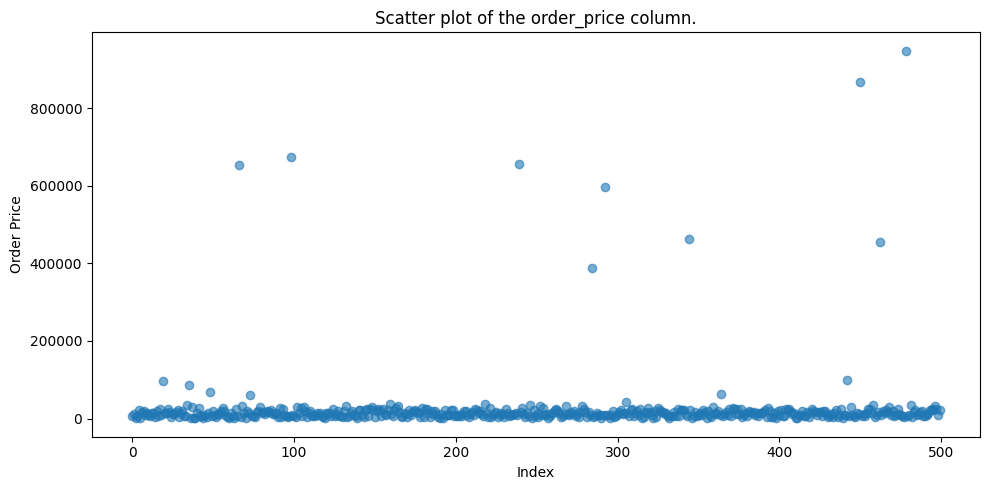

In [1137]:
# Draw scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(range(len(statistics)), statistics['order_price'], alpha=0.6)

plt.title("Scatter plot of the order_price column.")
plt.xlabel("Index")
plt.ylabel("Order Price")

# Display the plot
plt.tight_layout()
plt.show()

In [1138]:
# Calculate Q1 and Q3
Q1 = statistics['order_price'].quantile(0.25)
Q3 = statistics['order_price'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper thresholds
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter the outliers
outlier_statistics = statistics[(statistics['order_price'] < lower_limit) | (statistics['order_price'] > upper_limit)]

# Print the number of outliers
print("Number of outliers:", len(outlier_statistics))

Number of outliers: 16


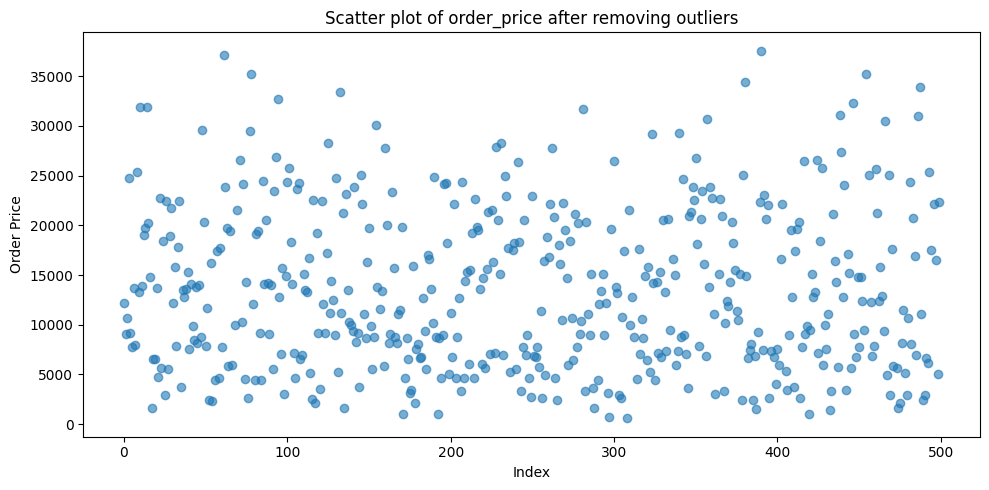

In [1139]:
# Calculate Q1, Q3, and IQR
Q1 = statistics['order_price'].quantile(0.25)
Q3 = statistics['order_price'].quantile(0.75)
IQR = Q3 - Q1

# Determine the lower and upper thresholds
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter out the outliers
clean_statistics = statistics[
    (statistics['order_price'] >= lower_limit) & 
    (statistics['order_price'] <= upper_limit)
]

plt.figure(figsize=(10, 5))
plt.scatter(clean_statistics.index, clean_statistics['order_price'], alpha=0.6)
plt.title("Scatter plot of order_price after removing outliers")
plt.xlabel("Index")
plt.ylabel("Order Price")
plt.tight_layout()
plt.show()

#### <b> 2. DESCRIPTIVE STATISTICS:

##### <b> •	Check the number and rate of satisfied customers

In [ ]:
# Group by "customer_id" and count the number of occurrences
duplicate_customers = (
    data_deficiency.groupby('customer_id')
    .size()
    .reset_index(name='n')
)

# Filter customers with number of occurrences greater than once
duplicate_customers = duplicate_customers[duplicate_customers['n'] > 1]

# Results
print("Number of customers who purchased more than once:", len(duplicate_customers))
print(duplicate_customers)


Number of customers who purchased more than once: 5
      customer_id  n
12   ID0052450505  2
74   ID0305909619  2
202  ID0660546021  2
251  ID0844490198  2
302  ID1492175313  2


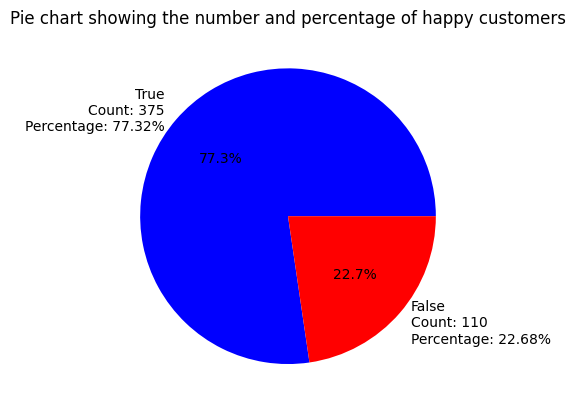

In [1160]:
# Remove duplicate records based on "customer_id"
unique_customers = data_deficiency.drop_duplicates(subset='customer_id')

# Count the number of records by "is_happy_customer"
count = unique_customers['is_happy_customer'].value_counts()

# Create labels for the chart showing both counts and percentages
labels = [
    f"{label}\nCount: {count[label]}\nPercentage: {round((count[label]/count.sum())*100, 2)}%"
    for label in count.index
]

# Draw a pie chart
plt.pie(count, labels=labels, colors=['blue', 'red'], autopct='%1.1f%%')
plt.title("Pie chart showing the number and percentage of happy customers")
plt.show()


##### <b> •	Check the number and percentage of warehouses

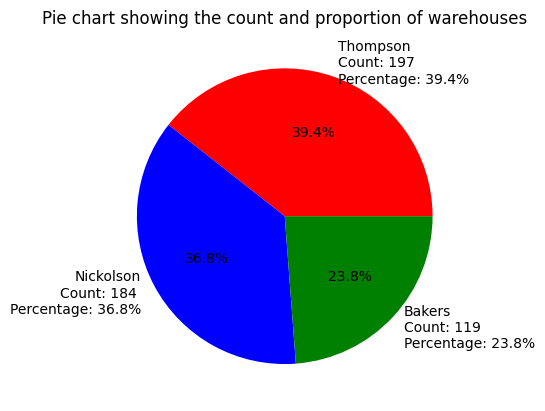

In [1142]:
# Calculate data for each warehouse
count = statistics['nearest_warehouse'].value_counts()

# Create labels for the pie chart showing both percentage and count
labels = [f"{name}\nCount: {count} \nPercentage: {round(count/len(statistics)*100, 3)}%" 
          for name, count in zip(count.index, count)]

# Plot a pie chart
plt.pie(count, labels=labels, colors=['red', 'blue', 'green'], autopct='%1.1f%%')
plt.title("Pie chart showing the count and proportion of warehouses")
plt.show()

##### <b> •	Find the monthly purchase frequency

In [1143]:
# Convert the date column to datetime data type
statistics['date'] = pd.to_datetime(statistics['date'])

# Calculate the monthly purchase frequency
purchase_freq_by_month = statistics['date'].dt.month.value_counts().sort_index()

# Results
print(purchase_freq_by_month)

date
1.0     47
2.0     38
3.0     35
4.0     41
5.0     43
6.0     38
7.0     32
8.0     37
9.0     50
10.0    46
11.0    39
12.0    34
Name: count, dtype: int64


##### <b> •	Plot the monthly purchase frequency of customers

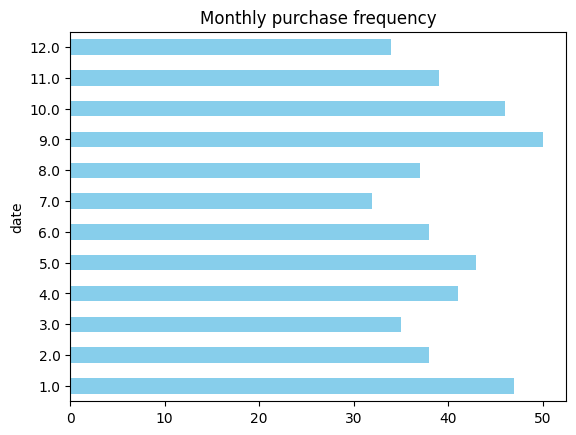

In [1144]:
# Convert the date column to datetime type if it has not been converted yet
statistics['date'] = pd.to_datetime(statistics['date'])

# Calculate the monthly purchase frequency
purchase_freq_by_month = statistics['date'].dt.month.value_counts().sort_index()

# Display the frequency horizontally
purchase_freq_by_month.plot(kind='barh', color='skyblue')
plt.title("Monthly purchase frequency")
plt.show()

In [1145]:
# Extract data from columns
dulieu_cut = statistics.iloc[:, [3, 5, 6, 7, 8, 9, 10, 12, 13, 15]]

##### <b> •	Draw some charts

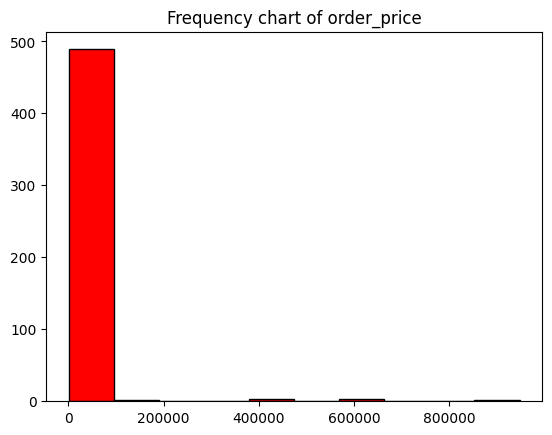

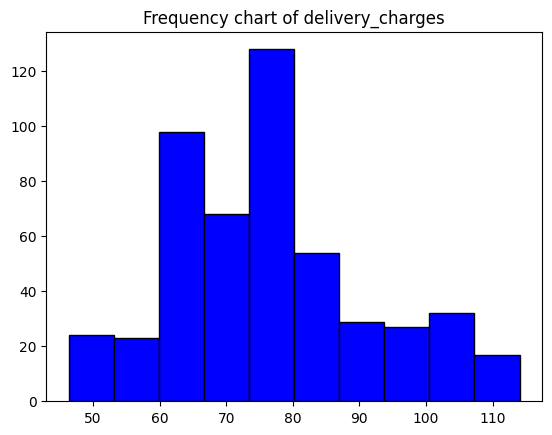

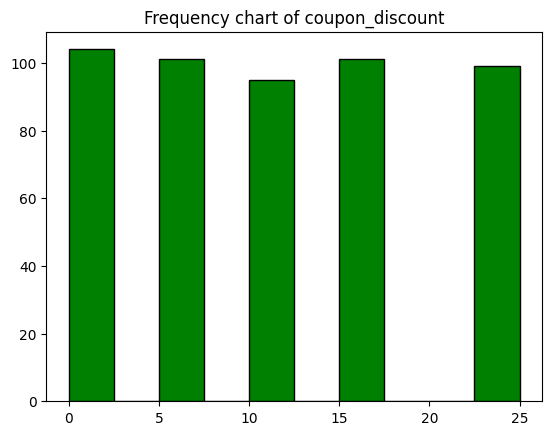

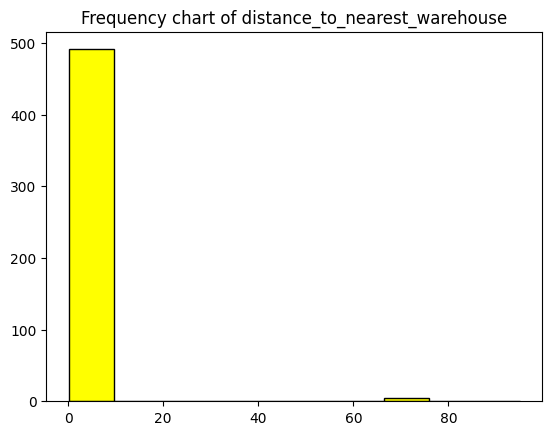

In [1146]:
# Plot frequency charts for the variables
plt.hist(dulieu_cut['order_price'], color='red', edgecolor='black')
plt.title("Frequency chart of order_price")
plt.show()

plt.hist(dulieu_cut['delivery_charges'], color='blue', edgecolor='black')
plt.title("Frequency chart of delivery_charges")
plt.show()

plt.hist(dulieu_cut['coupon_discount'], color='green', edgecolor='black')
plt.title("Frequency chart of coupon_discount")
plt.show()

plt.hist(dulieu_cut['distance_to_nearest_warehouse'], color='yellow', edgecolor='black')
plt.title("Frequency chart of distance_to_nearest_warehouse")
plt.show()

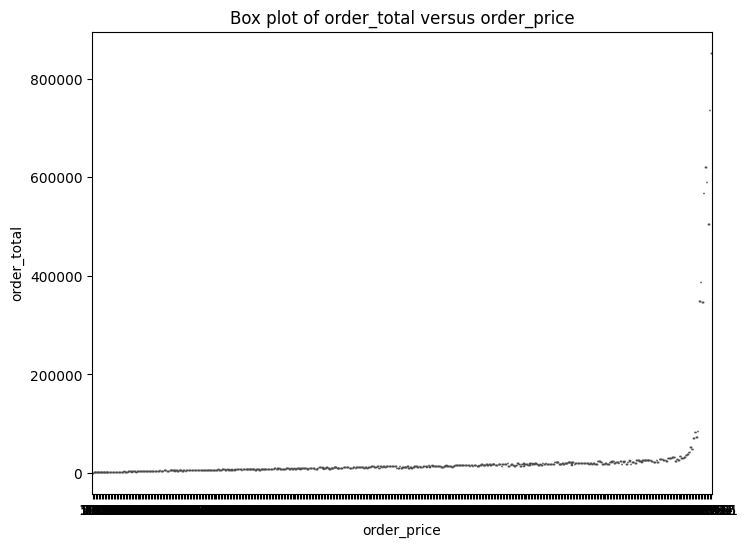

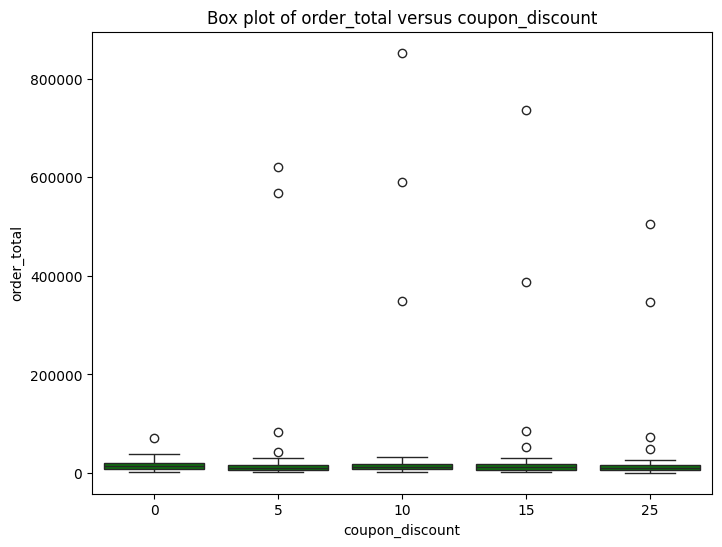

In [1147]:
# Create a box plot for order_total versus order_price
plt.figure(figsize=(8,6))
sns.boxplot(x='order_price', y='order_total', data=dulieu_cut, color='yellow')
plt.title("Box plot of order_total versus order_price")
plt.show()

# Create a box plot for order_total versus coupon_discount
plt.figure(figsize=(8,6))
sns.boxplot(x='coupon_discount', y='order_total', data=dulieu_cut, color='green')
plt.title("Box plot of order_total versus coupon_discount")
plt.show()

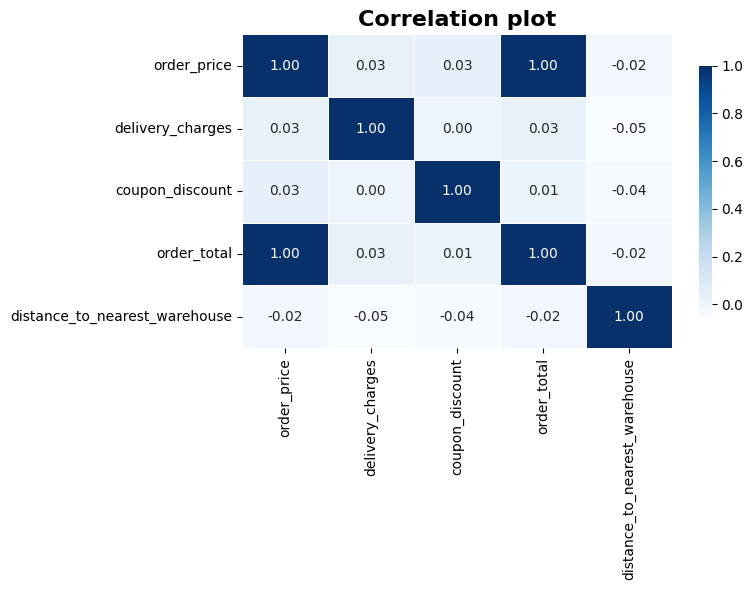

In [1148]:
# Calculate the correlation coefficient
dulieu_cut1 = statistics.iloc[:, [5, 6, 9, 10, 13]]
correlation_matrix = dulieu_cut1.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,               
    cmap='Blues',           
    fmt='.2f',              
    linewidths=0.5,          
    cbar_kws={'shrink': 0.8}  
)

plt.title("Correlation plot", fontsize=16, fontweight='bold') 
plt.xticks(rotation=90)   
plt.yticks(rotation=0)  
plt.tight_layout()     
plt.show()

##### <b> •	Inferential statistics

In [1149]:
# Statistical function for numerical variables
def statistics_mota(x):
    return pd.Series({
        "Min": x.min(),
        "1st Qu.": x.quantile(0.25),
        "Median": x.median(),
        "Mean": x.mean(),
        "3rd Qu.": x.quantile(0.75),
        "Max": x.max(),
        "NA's": x.isna().sum()
    })

# Statistical function for categorical variables
def statistics_object(x):
    mode_val = x.mode().iloc[0] if not x.mode().empty else np.nan
    freq_val = x.value_counts().iloc[0] if not x.value_counts().empty else np.nan
    return pd.Series({
        "Most frequent": mode_val,
        "Freq": freq_val,
        "Unique": x.nunique(),
        "NA's": x.isna().sum()
    })

# Numerical columns
cols_numeric = dulieu_cut.select_dtypes(include=[np.number]).columns
dinhluong = pd.DataFrame({col: statistics_mota(dulieu_cut[col]) for col in cols_numeric})

# Categorical columns
cols_object = dulieu_cut.select_dtypes(include=['object', 'bool']).columns
dinhchatluong = pd.DataFrame({col: statistics_object(dulieu_cut[col]) for col in cols_object})

In [1150]:
# Convert 'True' to 1 and 'False' to 0
statistics['is_happy_customer'] = statistics['is_happy_customer'].replace({'True': 1, 'False': 0})
statistics['is_expedited_delivery'] = statistics['is_expedited_delivery'].replace({'True': 1, 'False': 0})

In [1151]:
# Linear Regression Method
# Independent Variable
X = statistics[['customer_lat', 'customer_long']]
X = sm.add_constant(X)  

# Dependent Variable
y = statistics['distance_to_nearest_warehouse']

# Build the model
model = sm.OLS(y, X).fit()

# Print the detailed statistical results
print(model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     distance_to_nearest_warehouse   R-squared:                       0.000
Model:                                       OLS   Adj. R-squared:                 -0.004
Method:                            Least Squares   F-statistic:                   0.01849
Date:                           Tue, 20 May 2025   Prob (F-statistic):              0.982
Time:                                   09:17:53   Log-Likelihood:                -1797.0
No. Observations:                            500   AIC:                             3600.
Df Residuals:                                497   BIC:                             3613.
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [1152]:
# Build the ANOVA model
model = ols('distance_to_nearest_warehouse ~ delivery_charges', data=statistics).fit()

# Perform the ANOVA analysis
anova_result = sm.stats.anova_lm(model, typ=2)

# Print the results
print(anova_result)

                        sum_sq     df        F    PR(>F)
delivery_charges    107.437979    1.0  1.38453  0.239893
Residual          38644.240329  498.0      NaN       NaN


In [1153]:
# Make sure the variable is categorical
statistics['is_expedited_delivery'] = statistics['is_expedited_delivery'].astype('category')

# Build the ANOVA model
model = smf.ols('distance_to_nearest_warehouse ~ is_expedited_delivery', data=statistics).fit()

# Analysis of variance 
anova_result = sm.stats.anova_lm(model, typ=2)

# Print the results
print(anova_result)

                             sum_sq     df         F    PR(>F)
is_expedited_delivery      8.610178    1.0  0.110674  0.739518
Residual               38743.068130  498.0       NaN       NaN


In [1154]:
# Ensure binary variables
statistics['is_happy_customer'] = statistics['is_happy_customer'].astype(int)

# Logistic regression
model = smf.logit('is_happy_customer ~ order_price + delivery_charges + coupon_discount',
                  data=statistics).fit()

# Print the results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.499603
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      is_happy_customer   No. Observations:                  500
Model:                          Logit   Df Residuals:                      496
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 May 2025   Pseudo R-squ.:                  0.1601
Time:                        09:17:53   Log-Likelihood:                -249.80
converged:                       True   LL-Null:                       -297.42
Covariance Type:            nonrobust   LLR p-value:                 1.648e-20
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.0242      0.755     -6.657      0.000      -6.503      -3.545
order_price

#### <b> 3. SOME EXAMPLES:

##### <b> •	Testing a whole

In [1155]:
# Number of customers
n = 500

# Hypothetical ratio according to H0
p0 = 2/3

# Observed proportion in the sample
p_qsm = 359 / 500

# Standard error
se = math.sqrt(p0 * (1 - p0) / n)

# Test statistic value (Z score)
z = (p_qsm - p0) / se

# Level of importance
alpha = 0.05

# The critical value corresponds to the significance level
z_1 = norm.ppf(1 - alpha/2)

# Print the results
print("Z test value:", round(z, 4))
print("The critical value corresponds to the significance level.:", round(z_1, 4))

# Check conditions and draw conclusions
if abs(z) < z_1:
    print("Z is not in the region of rejection of H0!")
    print("There is not enough evidence to reject the null hypothesis H0!")
else:
    print("Z lies in the region of rejection of H0!")
    print("There is enough evidence to reject the null hypothesis H0!")


Z test value: 2.435
The critical value corresponds to the significance level.: 1.96
Z lies in the region of rejection of H0!
There is enough evidence to reject the null hypothesis H0!


##### <b> •	Overall inspection

In [1156]:
# Data
n1 = 119
m1 = 80
f1 = m1 / n1

n2 = 197
m2 = 142
f2 = m2 / n2

f = (f1 * n1 + f2 * n2) / (n1 + n2)

# Standard deviation
se = (f1 -f2) / math.sqrt(f * (1 - f) * (1/n1 + 1/n2))

# Significance level
alpha = 0.05

# The important value corresponds to the significance level.
z_alpha = norm.ppf(1 - alpha)

# Results
print(f"Standard value of inspection: z = {round(se, 4)}")
print(f"Value corresponding to significance level: {round(z_alpha, 4)}")

# Check conditions and draw conclusions
if abs(se) < z_alpha:
    print("There is not enough evidence to reject the null hypothesis H0!")
    print("There was no significant difference between customer satisfaction rates at the two warehouses!")
else:
    print("There is enough evidence to reject the null hypothesis H0!")
    print("Customer satisfaction rates are higher at Thompson's than at Bakers!")


Standard value of inspection: z = -0.9146
Value corresponding to significance level: 1.6449
There is not enough evidence to reject the null hypothesis H0!
There was no significant difference between customer satisfaction rates at the two warehouses!


##### <b> • Anova

In [1157]:
# Clean up is_expedited_delivery column
statistics['is_expedited_delivery'] = statistics['is_expedited_delivery'].astype(str).str.strip().str.upper()

# Filter and re-count
fast_shipping_quantity = statistics[
    statistics['is_expedited_delivery'] == 'TRUE'
].groupby('nearest_warehouse') \
 .size().reset_index(name='fast_shipping_quantity')

# Results
print(fast_shipping_quantity)

  nearest_warehouse  fast_shipping_quantity
0            Bakers                      60
1         Nickolson                      97
2          Thompson                      92


In [1158]:
# Make sure the date column has a datetime data type
statistics['date'] = pd.to_datetime(statistics['date'], errors='coerce')

# Add a month column containing the month the order was placed
statistics['month'] = statistics['date'].dt.to_period('M')

# Clean up the is_expedited_delivery column
statistics['is_expedited_delivery'] = statistics['is_expedited_delivery'].astype(str).str.strip().str.upper()

# Filter for expedited orders (is_expedited_delivery == 'TRUE')
fast_shipping_quantity = statistics[statistics['is_expedited_delivery'] == 'TRUE'] \
    .groupby(['month', 'nearest_warehouse']) \
    .size() \
    .unstack(fill_value=0)  

# Print statistical results
print(fast_shipping_quantity)

nearest_warehouse  Bakers  Nickolson  Thompson
month                                         
2019-01                 5          9         6
2019-02                 0          7         9
2019-03                 5          3         6
2019-04                 5          8         7
2019-05                 5         10         7
2019-06                 6          6        12
2019-07                 3          7         5
2019-08                 7         10         6
2019-09                 6         10         6
2019-10                 8          8         9
2019-11                 6          9         8
2019-12                 2          3         6


In [1159]:
# Data
thompson = np.array([6, 9, 8, 7, 13, 6, 6, 6, 10, 8, 6, 6], dtype=float) 
nickolson = np.array([9, 8, 5, 9, 12, 6, 7, 11, 10, 8, 9, 3], dtype=float)  
bakers = np.array([5, 0, 6, 6, 5, 6, 3, 6, 6, 8, 6, 2], dtype=float)  

# Create data frame from data
data = pd.DataFrame({
    'Customer': np.repeat(['Thompson', 'Nickolson', 'Bakers'], 12),
    'Month': np.tile(np.arange(1, 13), 3),
    'Requests': np.concatenate([thompson, nickolson, bakers])
})

# Create a data frame with 'Customer' as an element
data['Customer'] = data['Customer'].astype('category')

# Perform Anova with elements 'Requests' and 'Customer'
model = ols('Requests ~ Customer', data=data).fit()

# Print the results
print(model.summary())

# Get p-value from ANOVA
p_value = model.f_pvalue
print(f"P-value: {p_value}")

# Test hypothesis based on p-value
alpha = 0.05
if p_value < alpha:
    print("There is enough evidence to reject the null hypothesis H0!")
    print("There is a significant difference in fast delivery requirements between at least one pair of customers!")
else:
    print("There is insufficient evidence to reject the null hypothesis!")
    print("There is no significant difference in fast delivery requirements between customers!")


                            OLS Regression Results                            
Dep. Variable:               Requests   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     6.493
Date:                Tue, 20 May 2025   Prob (F-statistic):            0.00419
Time:                        09:17:53   Log-Likelihood:                -79.724
No. Observations:                  36   AIC:                             165.4
Df Residuals:                      33   BIC:                             170.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.91